## Dependencies

In [1]:
import gc
import re
import warnings
from joblib import dump
import tensorflow_hub as hub
from tensorflow.keras import Model, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout, Concatenate, BatchNormalization, Activation, Average, Add, Reshape
from tensorflow.keras.layers import GlobalAveragePooling1D, Embedding, LSTM, Conv1D, SpatialDropout1D, Bidirectional, Flatten
from googleqa_utilityscript import *


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## Load data

In [2]:
module_url = '/kaggle/input/universalsentenceencodermodels/universal-sentence-encoder-models/use'
model_path = '/kaggle/working/model.h5'
tokenizer_path = '/kaggle/working/tokenizer.joblib'
encoder_path = '/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl'

hold_out = pd.read_csv('/kaggle/input/googleqa-mldataset/hold-out.csv')
test = pd.read_csv('/kaggle/input/google-quest-challenge/test.csv')
train = hold_out[hold_out['set'] == 'train']
validation = hold_out[hold_out['set'] == 'validation']

print('Train samples: %s' % len(train))
print('Validation samples: %s' % len(validation))
display(train.head())

Train samples: 4863
Validation samples: 1216


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,set
0,3895,Magento (1.7) Bundled Product with FREE Produc...,I'm looking to create a bundle offer where cus...,Joe,https://magento.stackexchange.com/users/16572,"Since the third item is fixed, you can use sho...",Fabian Schmengler,https://magento.stackexchange.com/users/243,http://magento.stackexchange.com/questions/668...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,1.000000,0.000000,0.333333,0.888889,train
1,3131,Find router on network,I've just bought a Belkin N+ Wireless Router. ...,Guy,https://superuser.com/users/3248,You likely have the router plugged in to the m...,John T,https://superuser.com/users/1931,http://superuser.com/questions/87212,TECHNOLOGY,...,1.000000,0.666667,1.0,1.0,0.866667,0.666667,0.000000,1.000000,1.000000,train
2,1507,Negatively curved metrics minimizing the lengt...,Good afternoon everyone !\n\nI have the follow...,Selim G,https://mathoverflow.net/users/25511,A very partial answer: by the results of Richa...,Igor Rivin,https://mathoverflow.net/users/11142,http://mathoverflow.net/questions/203422,SCIENCE,...,0.888889,0.333333,1.0,1.0,0.700000,0.333333,0.333333,1.000000,0.888889,train
3,6784,Isn’t the FAQ label obsolete by now?,Don’t get me wrong in the beginning of reading...,Benny Skogberg,https://ux.stackexchange.com/users/4679,Isn’t the FAQ label obsolete by now? \n\nI'd s...,Solracnapod,https://ux.stackexchange.com/users/13153,http://ux.stackexchange.com/questions/18600/is...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,0.000000,0.000000,0.666667,1.000000,train
4,2135,Changing background image one time on responsi...,The code I'm using is this one \n\nbackground:...,user2141649,https://stackoverflow.com/users/2141649,&lt;!DOCTYPE html&gt;\n&lt;html&gt;\n&lt;head&...,akkimads,https://stackoverflow.com/users/2375373,http://stackoverflow.com/questions/16359492/ch...,STACKOVERFLOW,...,0.888889,0.500000,1.0,1.0,0.800000,1.000000,0.000000,0.000000,0.777778,train


In [3]:
question_target_cols = ['question_asker_intent_understanding','question_body_critical', 'question_conversational', 
                        'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
                        'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 
                        'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
                        'question_type_compare', 'question_type_consequence', 'question_type_definition', 
                        'question_type_entity', 'question_type_instructions', 'question_type_procedure',
                        'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']
answer_target_cols = ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
                      'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 
                      'answer_type_reason_explanation', 'answer_well_written']
target_cols = question_target_cols + answer_target_cols

## Pre-process data

In [4]:
text_features = ['question_title', 'question_body', 'answer']
text_features_uncased = ['question_title_uncased', 'question_body_uncased', 'answer_uncased']


for feature in text_features:
    # Map contractions
    train[feature] = train[feature].apply(lambda x: map_contraction(x))
    validation[feature] = validation[feature].apply(lambda x: map_contraction(x))
    test[feature] = test[feature].apply(lambda x: map_contraction(x))
    # Trim text
    train[feature] = train[feature].apply(lambda x: x.strip())
    validation[feature] = validation[feature].apply(lambda x: x.strip())
    test[feature] = test[feature].apply(lambda x: x.strip())

for feature in text_features:
    train[feature + '_uncased'] = train[feature]
    validation[feature + '_uncased'] = validation[feature]
    test[feature + '_uncased'] = test[feature]

for feature in text_features:
    # Lower
    train[feature] = train[feature].apply(lambda x: x.lower())
    validation[feature] = validation[feature].apply(lambda x: x.lower())
    test[feature] = test[feature].apply(lambda x: x.lower())

# Model parameters

In [5]:
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 3e-4
EMBEDDDING_SIZE = 512
N_CLASS = len(target_cols)
ES_PATIENCE = 5
RLROP_PATIENCE = 2
DECAY_DROP = 0.3
MAX_FEATURES = 10000
TITLE_MAX_LEN = 30
BODY_MAX_LEN = 150
ANSWER_MAX_LEN = 150

In [6]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)

tokenizer.fit_on_texts(list(train['question_title_uncased']) + list(validation['question_title_uncased']) + list(test['question_title_uncased']) +
                       list(train['question_body_uncased']) + list(validation['question_body_uncased']) + list(test['question_body_uncased']) +
                       list(train['answer_uncased']) + list(validation['answer_uncased']) + list(test['answer_uncased']))

## Train/validation sets

In [7]:
# Train features
# X_train_title = train['question_title']
# X_train_body = train['question_body']
# X_train_answer = train['answer']
X_train_title_seq = train['question_title_uncased']
X_train_body_seq = train['question_body_uncased']
X_train_answer_seq = train['answer_uncased']

# Tokenize the sentences
X_train_title_seq = tokenizer.texts_to_sequences(X_train_title_seq)
X_train_body_seq = tokenizer.texts_to_sequences(X_train_body_seq)
X_train_answer_seq = tokenizer.texts_to_sequences(X_train_answer_seq)

# Pad the sentences
X_train_title_seq = pad_sequences(X_train_title_seq, maxlen=TITLE_MAX_LEN)
X_train_body_seq = pad_sequences(X_train_body_seq, maxlen=BODY_MAX_LEN)
X_train_answer_seq = pad_sequences(X_train_answer_seq, maxlen=ANSWER_MAX_LEN)


X_train = [X_train_title_seq, X_train_body_seq, X_train_answer_seq]
Y_train = train[target_cols].values

# Validation features
# X_valid_title = validation['question_title']
# X_valid_body = validation['question_body']
# X_valid_answer = validation['answer']
X_valid_title_seq = validation['question_title_uncased']
X_valid_body_seq = validation['question_body_uncased']
X_valid_answer_seq = validation['answer_uncased']

# Tokenize the sentences
X_valid_title_seq = tokenizer.texts_to_sequences(X_valid_title_seq)
X_valid_body_seq = tokenizer.texts_to_sequences(X_valid_body_seq)
X_valid_answer_seq = tokenizer.texts_to_sequences(X_valid_answer_seq)

# Pad the sentences
X_valid_title_seq = pad_sequences(X_valid_title_seq, maxlen=TITLE_MAX_LEN)
X_valid_body_seq = pad_sequences(X_valid_body_seq, maxlen=BODY_MAX_LEN)
X_valid_answer_seq = pad_sequences(X_valid_answer_seq, maxlen=ANSWER_MAX_LEN)

X_valid = [X_valid_title_seq, X_valid_body_seq, X_valid_answer_seq]
Y_valid = validation[target_cols].values


print('Train samples: %d' % len(Y_train))
print('Validation samples: %d' % len(Y_valid))

Train samples: 4863
Validation samples: 1216


# Model

In [8]:
use_embed = hub.load(module_url)

def USEEmbedding(x):
    return use_embed(tf.squeeze(tf.cast(x, tf.string)))

def encoder_block(input_layer):
    encoder = Lambda(USEEmbedding, output_shape=(EMBEDDDING_SIZE,))(input_layer)
    
    return encoder

## Load embedding

In [9]:
glove_embedding_matrix, glove_unknown_words = build_matrix(tokenizer.word_index, encoder_path, MAX_FEATURES)
print('n unknown words (GloVe): ', len(glove_unknown_words))

n unknown words (GloVe):  685


In [10]:
# Title sequence
input_title_seq = Input(shape=(TITLE_MAX_LEN,), dtype=tf.float32, name='input_title_seq')
title = Embedding(*glove_embedding_matrix.shape, weights=[glove_embedding_matrix], trainable=False)(input_title_seq)
title = LSTM(128, kernel_initializer='lecun_normal', recurrent_dropout=0.5, return_sequences=True)(title)
title_out = LSTM(64, kernel_initializer='lecun_normal', recurrent_dropout=0.5, return_sequences=False)(title)
# title_out = GlobalAveragePooling1D()(title)

# Body sequence
input_body_seq = Input(shape=(BODY_MAX_LEN,), dtype=tf.float32, name='input_body_seq')
body = Embedding(*glove_embedding_matrix.shape, weights=[glove_embedding_matrix], trainable=False)(input_body_seq)
body = LSTM(128, kernel_initializer='lecun_normal', recurrent_dropout=0.5, return_sequences=True)(body)
body_out = LSTM(64, kernel_initializer='lecun_normal', recurrent_dropout=0.5, return_sequences=False)(body)
# body_out = GlobalAveragePooling1D()(body)

# Answer sequence
input_answer_seq = Input(shape=(ANSWER_MAX_LEN,), dtype=tf.float32, name='input_answer_seq')
answer = Embedding(*glove_embedding_matrix.shape, weights=[glove_embedding_matrix], trainable=False)(input_answer_seq)
answer = LSTM(128, kernel_initializer='lecun_normal', recurrent_dropout=0.5, return_sequences=True)(answer)
answer_out = LSTM(64, kernel_initializer='lecun_normal', recurrent_dropout=0.5, return_sequences=False)(answer)
# answer_out = GlobalAveragePooling1D()(answer)


# Output
x = Concatenate()([title_out, body_out, answer_out])
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_initializer='lecun_normal')(x)
x = Dropout(0.5)(x)
output = Dense(N_CLASS, activation='sigmoid', kernel_initializer='lecun_normal', name='output')(x)
model = Model(inputs=[input_title_seq, input_body_seq, input_answer_seq], outputs=[output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_title_seq (InputLayer)    [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_body_seq (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_answer_seq (InputLayer)   [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 300)      17424600    input_title_seq[0][0]            
______________________________________________________________________________________________

# Train model

In [11]:
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-7, verbose=1)
spearmanCallback = SpearmanRhoCallback(training_data=(X_train, Y_train), validation_data=(X_valid, Y_valid), monitor='val_loss', mode='min', patience=ES_PATIENCE)
callback_list = [rlrop, spearmanCallback]

optimizer = optimizers.Adam(LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

history = model.fit(X_train, Y_train, 
                    validation_data=(X_valid, Y_valid), 
                    callbacks=callback_list, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=2).history

Train on 4863 samples, validate on 1216 samples
Epoch 1/50
spearman-rho: 0.1790 val_spearman-rho: 0.1687
4863/4863 - 191s - loss: 0.4676 - val_loss: 0.4195
Epoch 2/50
spearman-rho: 0.2334 val_spearman-rho: 0.2190
4863/4863 - 172s - loss: 0.4200 - val_loss: 0.4081
Epoch 3/50
spearman-rho: 0.2586 val_spearman-rho: 0.2382
4863/4863 - 170s - loss: 0.4104 - val_loss: 0.4045
Epoch 4/50
spearman-rho: 0.2780 val_spearman-rho: 0.2540
4863/4863 - 170s - loss: 0.4053 - val_loss: 0.4019
Epoch 5/50
spearman-rho: 0.2918 val_spearman-rho: 0.2621
4863/4863 - 167s - loss: 0.4014 - val_loss: 0.3986
Epoch 6/50
spearman-rho: 0.3033 val_spearman-rho: 0.2664
4863/4863 - 168s - loss: 0.3983 - val_loss: 0.3969
Epoch 7/50
spearman-rho: 0.3120 val_spearman-rho: 0.2727
4863/4863 - 169s - loss: 0.3957 - val_loss: 0.3957
Epoch 8/50
spearman-rho: 0.3229 val_spearman-rho: 0.2783
4863/4863 - 163s - loss: 0.3932 - val_loss: 0.3941
Epoch 9/50
spearman-rho: 0.3324 val_spearman-rho: 0.2835
4863/4863 - 165s - loss: 0.3905

## Model loss graph

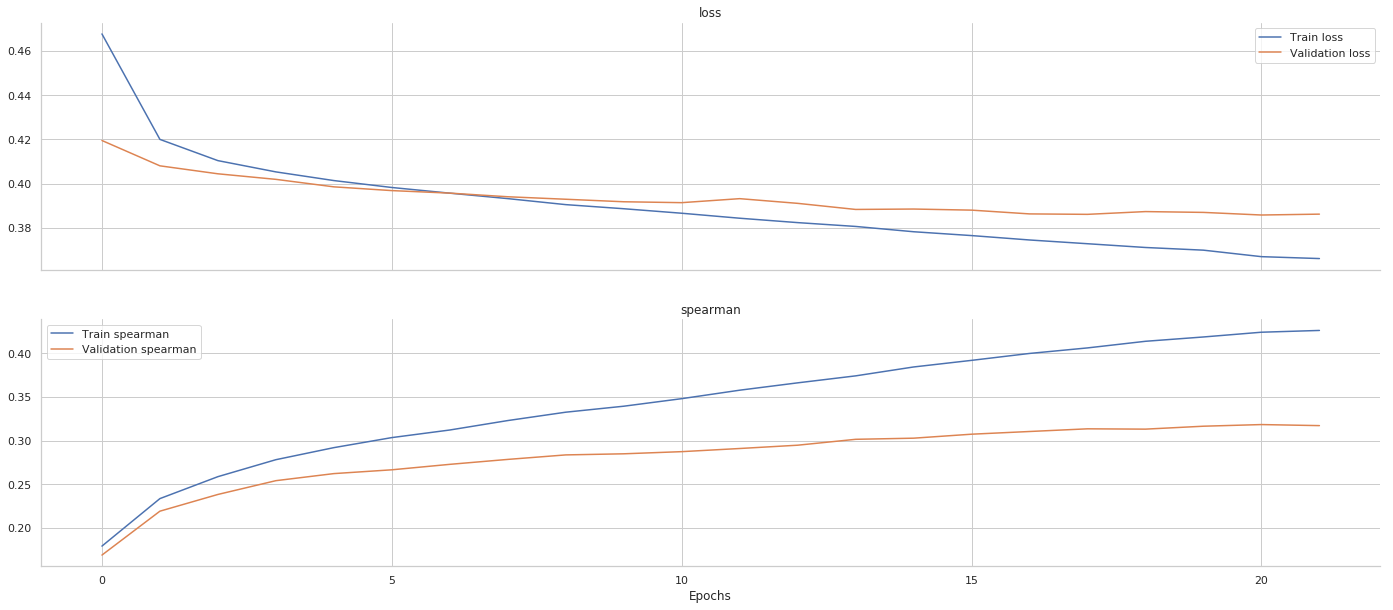

In [12]:
sns.set(style="whitegrid")
plot_metrics(history, metric_list=['loss', 'spearman'])

# Evaluation

In [13]:
preds_train = model.predict(X_train)
preds_val = model.predict(X_valid)

display(get_metrics(Y_train, preds_train, Y_valid, preds_val, target_cols).style.applymap(color_map))

,Label,Train,Validation
0,Averaged,0.426,0.317
1,question_asker_intent_understanding,0.382,0.31
2,question_body_critical,0.634,0.543
3,question_conversational,0.453,0.385
4,question_expect_short_answer,0.387,0.192
5,question_fact_seeking,0.475,0.301
6,question_has_commonly_accepted_answer,0.536,0.428
7,question_interestingness_others,0.352,0.309
8,question_interestingness_self,0.482,0.464
9,question_multi_intent,0.455,0.328


## By category

In [14]:
target_cols_preds = [col+'_pred' for col in target_cols]
for col in target_cols_preds:
    train[col] = 0
    validation[col] = 0
    
train[target_cols_preds] = preds_train
validation[target_cols_preds] = preds_val
    
display(get_metrics_category(train, validation, target_cols, target_cols_preds, 'category').style.applymap(color_map))

,Label,Train (TECHNOLOGY),Validation (TECHNOLOGY),Train (SCIENCE),Validation (SCIENCE),Train (STACKOVERFLOW),Validation (STACKOVERFLOW),Train (LIFE_ARTS),Validation (LIFE_ARTS),Train (CULTURE),Validation (CULTURE)
0,Averaged,0.394,0.277,0.443,0.288,0.322,0.168,0.424,0.322,0.416,0.311


#### Save model weights and ecoders

In [15]:
model.save_weights(model_path)
dump(tokenizer, tokenizer_path)

['/kaggle/working/tokenizer.joblib']